# Extreme Spatial: Demonstration
#### Author: Cheolhei Lee
#### Date: Jan 11. 2023

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from doe import lhd
from models import LatentExtreme, MaxStableProcess, SmithProcess, SchlatherProcess
from preprocess import BlockMaxima
import warnings
warnings.filterwarnings("ignore")

In this notebook, we present a short demo of `Extreme Spatial`, which has the following models in `models`.
- `LatentExtreme`: this model is used to estimate marginal generalized extreme value (GEV) parameters for observed sptial locations.
- `MaxStableProcess`: this is a conventional max-stable model class, which requires a random process such as `SmithProcess` or `SchlatherProcess`.

We fit a spatial extreme model for the maximum of 1-D function with spatially varying noise.

In [11]:
# define the 1-D function and spatially varying noise
def noise_fun(x):
    return stats.skewnorm(1, scale=np.exp(np.sin(np.pi * 2 * x)) * 0.05)

def f(x, noise=True):
    if noise:
        return np.exp(np.sin(np.pi * 2 * x)) * x + noise_fun(x).rvs(size=x.shape)
    else:
        return np.exp(np.sin(np.pi * 2 * x)) * x

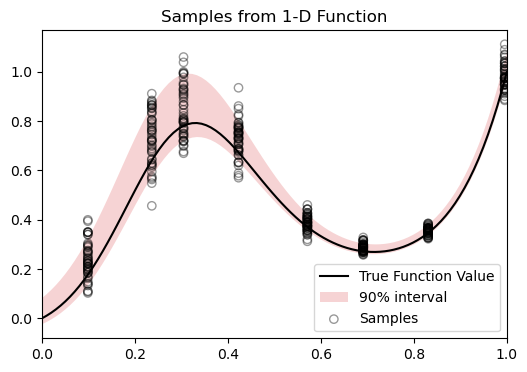

In [12]:
# replicate experiments at LatinHypercube-Maximin design points
reps = 50       # number of replications for each design point
q = 0.9         # quantile to visualize confidence interval
XX = np.linspace(0, 1, 100).reshape(-1, 1)
yy = f(XX, noise=False)
yy_ub = yy + noise_fun(XX).ppf(q)
yy_lb = yy + noise_fun(XX).ppf(1-q)
X = np.sort(lhd(8, 1, criterion='maximin', seed=0), 0)
X_reps = np.tile(X, reps); y = f(X_reps)

plt.figure(figsize=(6, 4))
plt.title('Samples from 1-D Function', fontsize=12)
plt.plot(XX, yy, 'k', label='True Function Value')
plt.fill_between(XX.ravel(), yy_lb.ravel(), yy_ub.ravel(), alpha=0.2, color='tab:red', edgecolors='None', label=f'{q:.0%} interval')
plt.scatter(X_reps, y, edgecolors='k', facecolor='None', alpha=0.4, label='Samples'); plt.margins(x=0); plt.legend(); plt.show()

We are interested in modeling the maximum values of the function, and we use `BlockMaxima` in `preprocess` to extract maxima values from observations.

In [13]:
bm = BlockMaxima(10)        # the block size is set to be 10
y_maxima = bm.get_maxima(y) # get maxima

Once the maxima are extracted, we fit `LatentExtreme` for marginal GEV parameters. `LatentExtreme` will estimate the marignal distribution for each location using maximum likelihood automatically.

In [14]:
kwargs = {'alpha': 1e-4, 'n_restarts_optimizer': 10}
le = LatentExtreme(input_dim=1, **kwargs)
le.fit(X, y_maxima)
yy_ci = le.predict_ppf(XX, q=[1-q, q])     # get quantiles for confidence interval visualization

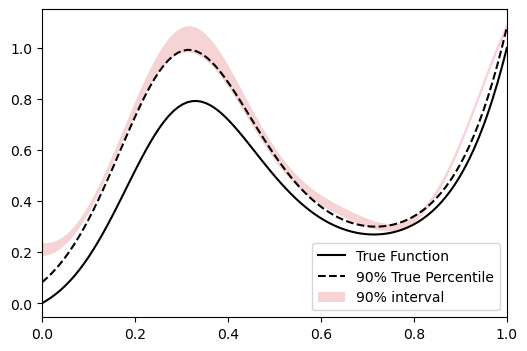

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(XX, yy, 'k', label='True Function')
plt.plot(XX, yy_ub, 'k--', label=f'{q:.0%} True Percentile')
plt.fill_between(XX.ravel(), yy_ci[:, 0].ravel(), yy_ci[:, 1].ravel(), alpha=0.2, color='tab:red', edgecolors='None', label=f'{q:.0%} interval')
plt.margins(x=0); plt.legend(loc=4); plt.show()

`LatentExtreme` can only model marginal distributions, so to sample from the extreme model, we need to make this model to a max-stable model. To build the max-stable model, we need to firstly transform data into unit Fr\'echet using `LatentExtreme.transform_unit_frec`.

In [16]:
z = le.transform_unit_frec()

In this note, we will use the Smith model (Smith, 1990) by embedding `SmithProcess` into `MaxStableProcess`. Fitting `MaxStableProcess` implements pairwise composite likelihood estimation to fit the random process, which captures the extremal dependency.

In [17]:
rp = SmithProcess(input_dim=1)
mp = MaxStableProcess(input_dim=1, random_process=rp)
mp.fit(X, z)

# get the estimated marginal parameters from LatentExtreme
params = le.get_params(XX)

# simulate 20 times
n_sim = 20
z_pred = []
for _ in range(n_sim):
    z_pred.append(mp.simulate(XX))
z_pred = np.column_stack(z_pred)

# inverse transform the 
y_pred = (1 - z_pred ** (-params[0][:, np.newaxis])) * params[2][:, np.newaxis] / params[0][:, np.newaxis] + params[1][:, np.newaxis]

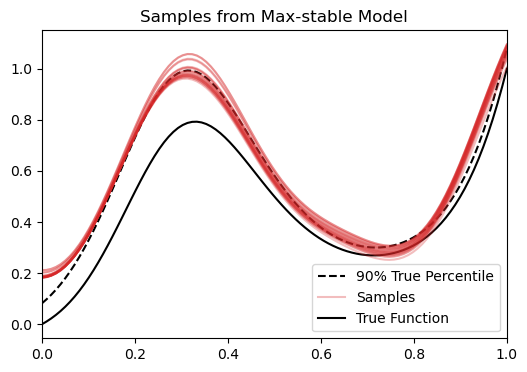

In [18]:
plt.figure(figsize=(6, 4)); plt.title('Samples from Max-stable Model', fontsize=12)
plt.plot(XX, yy, 'k', label='True Function')
plt.plot(XX, yy_ub, 'k--', label=f'{q:.0%} True Percentile')
plt.plot(XX, y_pred, 'tab:red', alpha=0.3, label='Samples'); 
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[_] for _ in ids]
plt.legend(handles, labels, loc=4)
plt.margins(x=0); plt.show()